<a href="https://colab.research.google.com/github/BaranTacyildiz/TSLA_Forecasting_LSTM/blob/main/TSLA_Forecasting_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Dec 15 10:35:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import yfinance as yf
import pandas as pd

# Firstly we are gonna extract data from yahoo finance about Tesla
tsla = yf.Ticker("TSLA")
data = tsla.history(start="2018-03-13", end="2024-12-13")

# Converting data to .csv format and from .csv to pd dataframe format
csv_file_name = "TSLA_data.csv"
data.to_csv(csv_file_name)
df = pd.read_csv(csv_file_name)
df


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-03-13 00:00:00-04:00,21.907333,23.147333,21.766666,22.789333,89487000,0.0,0.0
1,2018-03-14 00:00:00-04:00,22.450666,22.653999,21.595333,21.775333,119511000,0.0,0.0
2,2018-03-15 00:00:00-04:00,21.958668,22.190001,21.406668,21.706667,98472000,0.0,0.0
3,2018-03-16 00:00:00-04:00,21.528667,21.826668,21.271334,21.423332,91759500,0.0,0.0
4,2018-03-19 00:00:00-04:00,21.100000,21.383333,20.644667,20.903999,112264500,0.0,0.0
...,...,...,...,...,...,...,...,...
1696,2024-12-06 00:00:00-05:00,377.420013,389.489990,370.799988,389.220001,81455800,0.0,0.0
1697,2024-12-09 00:00:00-05:00,397.609985,404.799988,378.010010,389.790009,96359200,0.0,0.0
1698,2024-12-10 00:00:00-05:00,392.679993,409.730011,390.850006,400.989990,97563600,0.0,0.0
1699,2024-12-11 00:00:00-05:00,409.700012,424.880005,402.380005,424.769989,104287600,0.0,0.0


In [ ]:
df = df[["Date","Close"]]
df

,Date,Close
0,2018-03-13 00:00:00-04:00,22.789333
1,2018-03-14 00:00:00-04:00,21.775333
2,2018-03-15 00:00:00-04:00,21.706667
3,2018-03-16 00:00:00-04:00,21.423332
4,2018-03-19 00:00:00-04:00,20.903999
...,...,...
1696,2024-12-06 00:00:00-05:00,389.220001
1697,2024-12-09 00:00:00-05:00,389.790009
1698,2024-12-10 00:00:00-05:00,400.989990
1699,2024-12-11 00:00:00-05:00,424.769989


In [ ]:
# A function for prepare date format year-month-day and dtype = datetime64 (in original data its object)

import datetime

def str_to_datetime(s):
  split = s.split(" ")
  split = split[0].split("-")
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

# Example
datetime_object = str_to_datetime('2005-03-25')
datetime_object

datetime.datetime(2005, 3, 25, 0, 0)

In [ ]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-5-f6fc52bb0fa5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


,Date
0,2018-03-13
1,2018-03-14
2,2018-03-15
3,2018-03-16
4,2018-03-19
...,...
1696,2024-12-06
1697,2024-12-09
1698,2024-12-10
1699,2024-12-11


In [ ]:
df.index = df.pop("Date")
df

,Close
Date,
2018-03-13,22.789333
2018-03-14,21.775333
2018-03-15,21.706667
2018-03-16,21.423332
2018-03-19,20.903999
...,...
2024-12-06,389.220001
2024-12-09,389.790009
2024-12-10,400.989990


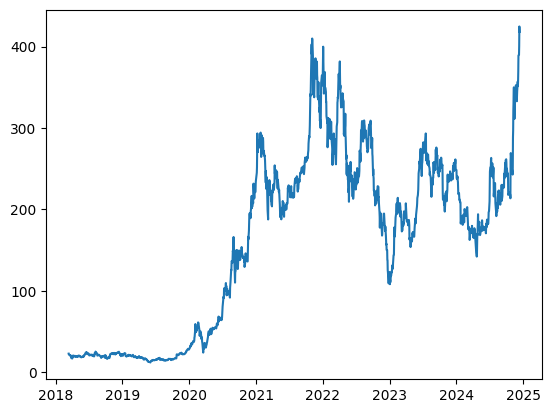

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [ ]:
# Preparing the past data to train model predict target price.

import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df,
                                '2018-03-24',
                                '2024-12-12',
                                n=7)
windowed_df

,Target Date,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2018-03-24,21.775333,21.706667,21.423332,20.903999,20.703333,21.101999,20.606667,20.102667
1,2018-03-27,21.423332,20.903999,20.703333,21.101999,20.606667,20.102667,20.278667,18.612000
2,2018-03-28,20.903999,20.703333,21.101999,20.606667,20.102667,20.278667,18.612000,17.185333
3,2018-03-29,20.703333,21.101999,20.606667,20.102667,20.278667,18.612000,17.185333,17.742001
4,2018-04-02,21.101999,20.606667,20.102667,20.278667,18.612000,17.185333,17.742001,16.832001
...,...,...,...,...,...,...,...,...,...
1687,2024-12-06,338.230011,332.890015,345.160004,357.089996,351.420013,357.929993,369.489990,389.220001
1688,2024-12-09,332.890015,345.160004,357.089996,351.420013,357.929993,369.489990,389.220001,389.790009
1689,2024-12-10,345.160004,357.089996,351.420013,357.929993,369.489990,389.220001,389.790009,400.989990
1690,2024-12-11,357.089996,351.420013,357.929993,369.489990,389.220001,389.790009,400.989990,424.769989


In [ ]:
# Seperating data to date, X, y

# Date and y will be the two axes of the graph. X will be the data we will train the model on.

def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((1692,), (1692, 7, 1), (1692,))

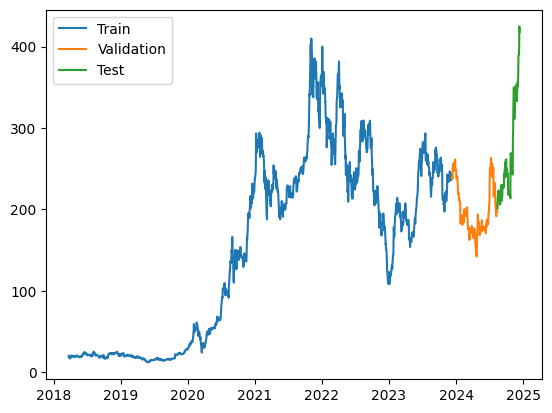

In [ ]:
# Prepare train, validation and test data

# Train %85, Validation %10, Test %5

q_85 = int(len(dates) * .85)
q_95 = int(len(dates) * .95)

dates_train, X_train, y_train = dates[:q_85], X[:q_85], y[:q_85]

dates_val, X_val, y_val = dates[q_85:q_95], X[q_85:q_95], y[q_85:q_95]
dates_test, X_test, y_test = dates[q_95:], X[q_95:], y[q_95:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((7, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30)

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 35203.4844 - mean_absolute_error: 149.1066 - val_loss: 37462.6523 - val_mean_absolute_error: 191.1625
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 30099.4355 - mean_absolute_error: 133.4761 - val_loss: 16283.1689 - val_mean_absolute_error: 123.8810
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13864.7861 - mean_absolute_error: 92.0679 - val_loss: 312.2131 - val_mean_absolute_error: 12.2794
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1221.1000 - mean_absolute_error: 17.7568 - val_loss: 87.4864 - val_mean_absolute_error: 6.6042
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 300.0426 - mean_absolute_error: 8.6454 - val_loss: 89.0225 - val_mean_absolute_error: 7.2957
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 154.6813 - mean_absolute_error: 6.6974 - val_loss: 66.3454 - val_mean_absolute_error: 5.9648
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 101.6056 - 

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


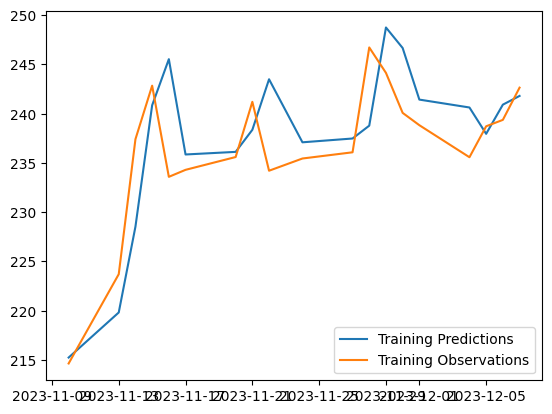

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train[-20:-1], train_predictions[-20:-1])
plt.plot(dates_train[-20:-1], y_train[-20:-1])
plt.legend(['Training Predictions', 'Training Observations'])


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


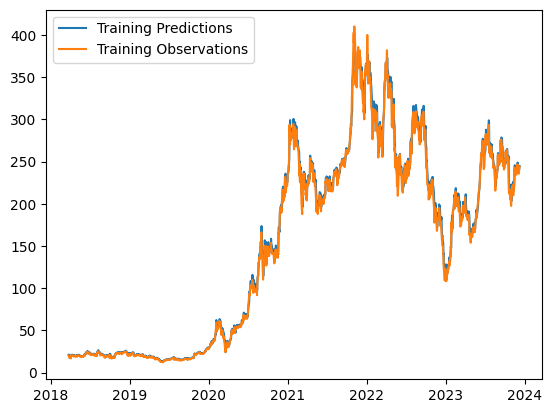

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


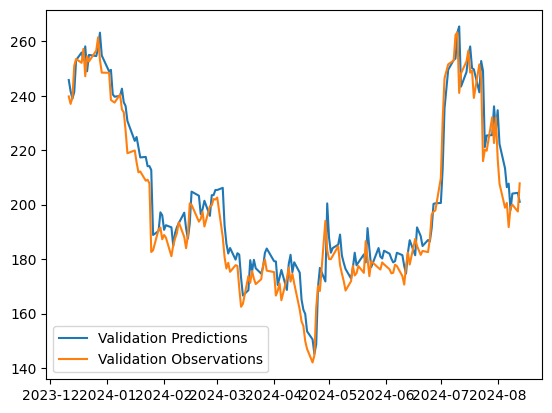

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


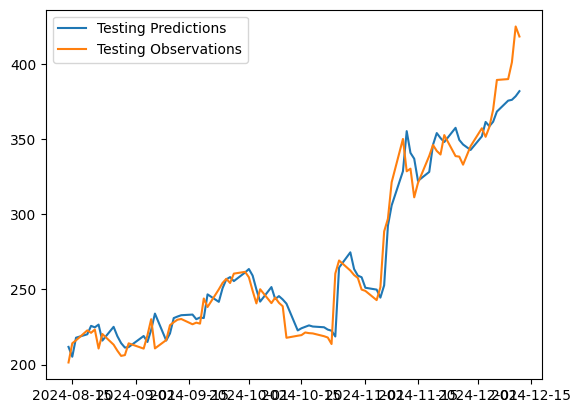

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

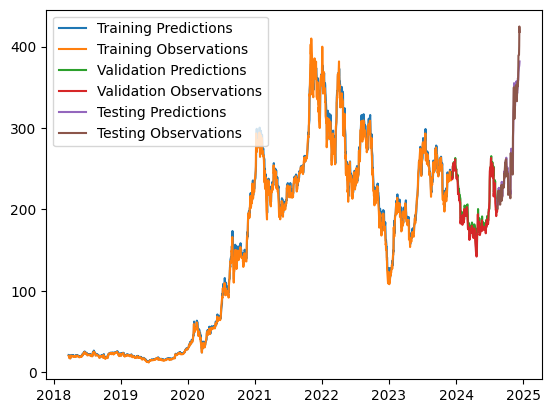

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [ ]:
# To predict tomorrow

test_prediction = model.predict(X_test[-1:])
test_prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


array([[381.76047]], dtype=float32)